In [1]:
#hide
!pip3 install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
# Note: the steps to get a 'free' api key for this are annoying. 
# You have to create a new azure/microsoft account, put up a credit card, create a new resource group,
# deploy a new bingsearchv7 instance in azure, and then navigate to the dashbaord and find your key.

import os
from fastai.vision.all import *
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api

# see https://github.com/fastai/fastbook/blob/master/utils.py#
def search_images_bing(key, term, min_sz=128):
    client = api('https://api.cognitive.microsoft.com', auth(key))
    return L(client.images.search(query=term, count=150, min_height=min_sz, min_width=min_sz).value)

In [4]:
key = os.environ['AZURE_SEARCH_KEY']

results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)


150

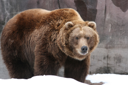

In [9]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

im = Image.open(dest)
im.to_thumb(128,128)

In [11]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('content_url'))

In [15]:
fns = get_image_files(path)
fns

(#423) [Path('bears/grizzly/00000038.jpg'),Path('bears/grizzly/00000004.jpg'),Path('bears/grizzly/00000005.jpg'),Path('bears/grizzly/00000011.jpg'),Path('bears/grizzly/00000039.jpg'),Path('bears/grizzly/00000007.jpg'),Path('bears/grizzly/00000012.png'),Path('bears/grizzly/00000006.jpg'),Path('bears/grizzly/00000120.gif'),Path('bears/grizzly/00000002.jpg')...]

In [16]:
# check for corrupt image files
failed = verify_images(fns)
failed

(#0) []

In [17]:
failed.map(Path.unlink);

In [22]:
# Note: to inspect/lear more about a given function, you can type ??[method_name] into a cell and run it. 
# For example:
??verify_images

In [19]:
# DataLoaders
#
# when your application/data structure doesn't fit into one of the predefined methods, you can instead
# use the flexible system called the data block api. With this api, you can fully customize every stage of
# the creation of your DataLoaders.
#
# First, we provide a tuple specifying the types we want for the independent and dependent variables (image, category):
#
#   blocks=(ImageBlock, CategoryBlock)
#
# The *independent variable* is the thing we are using to make predictions from. 
# The *dependent variable* is our target.
# In this case our independent variables is a set of images, our dependent variables are the categories 
# (type of bear) for each image.
#
# For this DataLoaders, our underlying items will be file paths. We have to tell fastai
# how to get a list of those files. The get_image_files function takes a path, and returns a list of all of the images
# in that path:
#
#   get_items=get_image_files
#
# Often, datasets you download will already have a validation set defined. In this case, we want to split our
# training and validation sets randomly. However we would like to have the same training/validation split each time
# we run this notebook, so we will fix the random seed:
#
#   splitter=RandomSplitter(valid_pct=0.2, seed=42)
#
# The independent variable is often called x, and the dependent variable is often called y, so here we want to
# tell fastai what function to call to create the labels in our dataset:
#
#   get_y=parent_label
#
# parent_label is a function provided by fastai that simply gets the name of the folder a file is in. Our bear images
# were divided earlier into 3 folders with the names grizzly, black and teddy, so in this case these will also be 
# our labels.
#
# Our images are all different sizes, which is a problem for deep learning. We don't feed the model one image at a time,
# but several mini-batches of them. To group them in a big array (usually called a tensor) that is going to go
# through our model, they all need to be of the same size. So, we need to add a transform that wil resize these images
# to the same size:
#
#   item_tfms=Resize(128)
#
# Item transforms are pieces of code that run on each individual item, whether it be an image, category, or so forth.
#
# So now, we can put all of this together to create a DataBlock object:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))


In [25]:
# This is like a template for creating a DataLoaders. We still need to tell fastai the actual source of our data, in this case the path where the images can be found:
dls = bears.dataloaders(path)


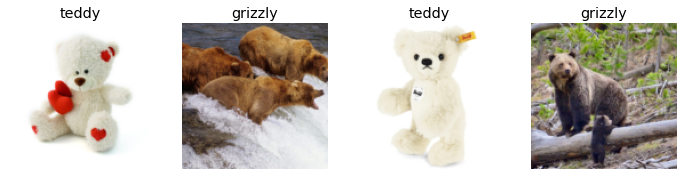

In [26]:
# A DataLoader is a class that provides batches of a few items at a time to the GPU. When you loop through a 
# DataLoader, fastai will give you 64 (by default) items at a time, all stacked up into a single tensor.
# We can take a look at a few of those items by calling the show_batch method on a DataLoader:
dls.valid.show_batch(max_n=4, nrows=1)


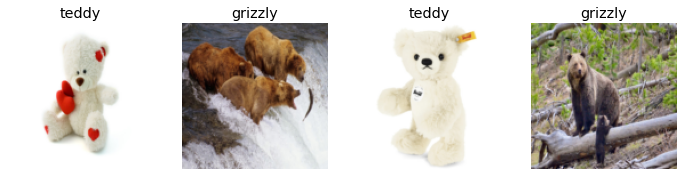

In [28]:
# By default, Resize (used in our trasnform above) will crop the images to fit a square shape. 
# We can alternatively ask fastai to pad or squish the images instead:

# Example: squish
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [29]:
# Example: pad
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [33]:
# Note: cropping/squishing/stretching/padding our images can be a problem, and may result in lowered accuracy
# of our model.
# Instead, we should randomly select part of the images then crop to just that part. On each epoch (One complete
# pass through all of our images in the dataset), we randomly select a different part of each image. 
# This means our model can learn to focus on and recognize different features in our images.
#
# What we can do then is replace *Resize* with *RandomResizedCrop*, which is a transform that applies the behavior
# described above.
#
# *min_scale* - determines how much of the images to select at minimum each time.
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [34]:
# So now, we can train our model.
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [35]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/zayne/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


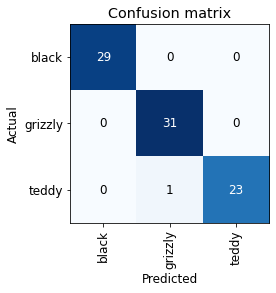

In [36]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [37]:
# in the example above we can see we had 1 miss (predicted grizzly, actual teddy). Let's plot our top losses:
interp.plot_top_losses(5, nrows=1)

In [38]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [39]:
# delete images marked for deletion
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [42]:
# export our data to a .pkl file
learn.export()